## 数据集准备和获取
### 📖从相关网站爬取数据
下载好的数据集已经放在了data目录下，还有甲骨文字体包，我们要从原始数据网站上获取数据集，由于数据集获取方式不唯一，这里没有贴出数据集的下载代码

```bash
.data/
├── AYJGW.DvV-wIBv.ttf 
├── jgw_detail_ay_1530.jsonl
├── jgw_detail_vl_web_725.jsonl
```

<details style="color:rgb(128,128,128)">
<summary>注：各数据集简介</summary>

* `AYJGW.DvV-wIBv.ttf` --甲骨文字体库
* `jgw_detail_ay_1530.jsonl` --甲骨文网站所收录的可释义甲骨文字体数据集
* `jgw_detail_vl_web_725.jsonl` --说文解字中可释义甲骨文字体数据集


</details>

## 甲骨文图片
从甲骨文字体库加载并生成甲骨文图片


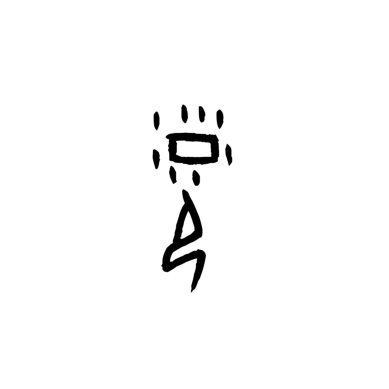

In [1]:
# 测试是否能显示甲骨文字符图片
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 字体文件路径和字符
font_path = './data/AYJGW.DvV-wIBv.ttf'
char = '\U0006017D'  # U+6017D

# 创建图像
img = Image.new('RGB', (2000, 2000), color='white')
draw = ImageDraw.Draw(img)

# 加载字体
try:
    font = ImageFont.truetype(font_path, 1000)
except Exception as e:
    print(f"字体加载失败: {e}")
    exit()

# 使用 textbbox 计算文字边框
bbox = draw.textbbox((0, 0), char, font=font)
text_width = bbox[2] - bbox[0]
text_height = bbox[3] - bbox[1]

# 居中绘制
x = (img.width - text_width) // 2
y = (img.height - text_height) // 2
draw.text((x, y), char, font=font, fill='black')

# 显示图像
plt.imshow(img)
plt.axis('off')
# plt.title(f"Character U+6017D in {font_path}")
plt.show()


## 将所有爬取的甲骨文字符id转化为对应的图片

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import json
import os

# 字体文件路径
font_path = './data/AYJGW.DvV-wIBv.ttf'
output_dir = "./data/jgw_vl_total"

# 创建输出文件夹
os.makedirs(output_dir, exist_ok=True)

# 加载字体
try:
    font = ImageFont.truetype(font_path, 100)
except Exception as e:
    print(f"字体加载失败: {e}")
    exit()

# 打开 JSONL 文件
with open("jgw_detail_ay_1530.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line)
            font_code = data["Response"]["Data"]["FontImgUrl"]  # e.g. "U6017D"
            char_id = font_code

            if not font_code.startswith("U"):
                print(f"跳过无效编码: {font_code}")
                continue

            unicode_value = int(font_code[1:], 16)
            char = chr(unicode_value)

            # 创建画布
            img = Image.new('RGB', (200, 200), color='white')
            draw = ImageDraw.Draw(img)

            bbox = draw.textbbox((0, 0), char, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            x = (img.width - text_width) // 2
            y = (img.height - text_height) // 2

            draw.text((x, y), char, font=font, fill='black')

            # 保存图片
            file_path = os.path.join(output_dir, f"{char_id}.png")
            img.save(file_path)
            print(f"✅ 已保存: {file_path}")

        except Exception as e:
            print(f"❌ 处理出错: {e}")


### 到目前为止，已经成功保存了甲骨文字符的图片,并且获得每个字符图片进行的描述
### 接下来就可以进行多模态模型的lora微调训练了，这里选择Qwen2-VL-2B模型
<a rel="nofollow" style="margin: 2px;" href="https://chat.qwenlm.ai/">
    <img style="display: inline-block; vertical-align: middle;" src="https://img.shields.io/badge/%F0%9F%92%9C%EF%B8%8F%20Qwen%20Chat%20-536af5" alt="Chat">
</a>

处理数据,将甲骨文图片和对应释义写成模型训练所需的格式


In [ ]:
import json
with open("jgw_detail_vl_web_725.jsonl", "r") as f:
    lines = f.readlines()
    data = [json.loads(line) for line in lines]
conversations = []

# 添加对话数据

for i in data:
    conversations.append({
        "id": f"identity_{i['word']}",
        "conversations": [
            {
                "from": "user",
                "value": f"&lt;|vision_start|&gt;/home/aistudio/jgw_vl_total/{i['word'][:6]}.png&lt;|vision_end|&gt;"
            },
            {
                "from": "assistant",
                "value": i['baihua']
            }
        ]
    })

with open('./data/data_vl.json', 'w', encoding='utf-8') as f:
    json.dump(conversations, f, ensure_ascii=False, indent=2)

## 🤖 模型下载与加载

这里使用 `modelscope` 提供的 `snapshot_download` 函数进行下载，该方法对国内的用户十分友好。然后把它加载到Transformers中进行训练：

In [ ]:

from modelscope import snapshot_download, AutoTokenizer
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq, Qwen2VLForConditionalGeneration, AutoProcessor
import torch

# 在modelscope上下载Qwen2-VL模型到本地目录下
model_dir = snapshot_download("Qwen/Qwen2-VL-2B-Instruct", cache_dir="./", revision="master")

# 使用Transformers加载模型权重
tokenizer = AutoTokenizer.from_pretrained("./Qwen/Qwen2-VL-2B-Instruct/", use_fast=False, trust_remote_code=True)
# 特别的，Qwen2-VL-2B-Instruct模型需要使用Qwen2VLForConditionalGeneration来加载
model = Qwen2VLForConditionalGeneration.from_pretrained("./Qwen/Qwen2-VL-2B-Instruct/", device_map="auto", torch_dtype=torch.bfloat16, trust_remote_code=True,)
model.enable_input_require_grads()  # 开启梯度检查点时，要执行该方法




模型大小约 4.5GB，下载模型大概需要 5 - 10 分钟。

In [ ]:
#导入所需的包
import torch
from datasets import Dataset
from modelscope import snapshot_download, AutoTokenizer
from qwen_vl_utils import process_vision_info
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    Qwen2VLForConditionalGeneration,
    AutoProcessor,
)
import json


### 构建一个函数来把模型的输入数据转换为模型的输入格式

In [ ]:

def process_func(example):
    """
    将数据集进行预处理
    """
    MAX_LENGTH = 8192
    input_ids, attention_mask, labels = [], [], []
    conversation = example["conversations"]
    input_content = conversation[0]["value"]
    output_content = conversation[1]["value"]
    file_path = input_content.split("&lt;|vision_start|&gt;")[1].split("&lt;|vision_end|&gt;")[0]  # 获取图像路径
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": f"{file_path}",
                    "resized_height": 200,
                    "resized_width": 200,
                },
                {"type": "text", "text": "JGw Yes:"},
            ],
        }
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )  # 获取文本
    image_inputs, video_inputs = process_vision_info(messages)  # 获取数据数据（预处理过）
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = {key: value.tolist() for key, value in inputs.items()} #tensor -&gt; list,为了方便拼接
    instruction = inputs

    response = tokenizer(f"{output_content}", add_special_tokens=False)


    input_ids = (
            instruction["input_ids"][0] + response["input_ids"] + [tokenizer.pad_token_id]
    )

    attention_mask = instruction["attention_mask"][0] + response["attention_mask"] + [1]
    labels = (
            [-100] * len(instruction["input_ids"][0])
            + response["input_ids"]
            + [tokenizer.pad_token_id]
    )
    if len(input_ids) &gt; MAX_LENGTH:  # 做一个截断
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]

    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    labels = torch.tensor(labels)
    inputs['pixel_values'] = torch.tensor(inputs['pixel_values'])
    inputs['image_grid_thw'] = torch.tensor(inputs['image_grid_thw']).squeeze(0)  #由（1,h,w)变换为（h,w）
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels,
            "pixel_values": inputs['pixel_values'], "image_grid_thw": inputs['image_grid_thw']}


In [ ]:

def predict(messages, model):
    # 准备推理
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # 生成输出
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0]

# 使用Transformers加载模型权重
tokenizer = AutoTokenizer.from_pretrained("./Qwen/Qwen2-VL-2B-Instruct/", use_fast=False, trust_remote_code=True)
processor = AutoProcessor.from_pretrained("./Qwen/Qwen2-VL-2B-Instruct")

model = Qwen2VLForConditionalGeneration.from_pretrained("./Qwen/Qwen2-VL-2B-Instruct/", device_map="auto", torch_dtype=torch.bfloat16, trust_remote_code=True,)
model.enable_input_require_grads()  # 开启梯度检查点时，要执行该方法

# 处理数据集：读取json文件
# 拆分成训练集和测试集，保存为data_vl_train.json和data_vl_test.json
train_json_path = "./data/data_vl.json"
with open(train_json_path, 'r') as f:
    data = json.load(f)
    train_data = data[:-4]
    test_data = data[-4:]

with open("./data/data_vl_train.json", "w") as f:
    json.dump(train_data, f)

with open("./data/data_vl_test.json", "w") as f:
    json.dump(test_data, f)

train_ds = Dataset.from_json("./data/data_vl_train.json")
train_dataset = train_ds.map(process_func)

# 配置LoRA
config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    inference_mode=False,  # 训练模式
    r=64,  # Lora 秩
    lora_alpha=16,  # Lora alaph，具体作用参见 Lora 原理
    lora_dropout=0.05,  # Dropout 比例
    bias="none",
)

# 获取LoRA模型
peft_model = get_peft_model(model, config)

args = TrainingArguments(
    output_dir="./output/Qwen2-VL-2B",
    per_device_train_batch_size=6,                # 如果是单卡32G，建议尝试 8 或更大
    gradient_accumulation_steps=1,                # 不累积梯度，能快就快
    logging_steps=20,                             # 不用太频繁打印日志
    num_train_epochs=50,                           # 快速训练建议先1个epoch看看结果
    save_steps=100,                               # 减少保存频率以节省IO时间
    learning_rate=1e-4,                           # 对LoRA可调高学习率，加快收敛
    save_on_each_node=False,                      # 单机单卡可关闭
    gradient_checkpointing=True,                 # 关闭可节省时间但消耗更多显存（32G够用）
    report_to="none",
    fp16=True,                                    # 启用半精度训练，提升速度，减少显存
)
        
# 配置Trainer
trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)
# 开启模型训练
trainer.train()


## 来验证刚刚lora微调的模型的效果

In [ ]:

# ===测试模式===
# 配置测试参数
val_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    inference_mode=True,  # 训练模式
    r=64,  # Lora 秩
    lora_alpha=16,  # Lora alaph，具体作用参见 Lora 原理
    lora_dropout=0.05,  # Dropout 比例
    bias="none",
)

# 获取测试模型
val_peft_model = PeftModel.from_pretrained(model, model_id="./output/Qwen2-VL-2B/checkpoint-100", config=val_config)

# 读取测试数据
with open("data_vl_test.json", "r") as f:
    test_dataset = json.load(f)

test_image_list = []
for item in test_dataset:
    input_image_prompt = item["conversations"][0]["value"]
    # 去掉前后的&lt;|vision_start|&gt;和&lt;|vision_end|&gt;
    origin_image_path = input_image_prompt.split("&lt;|vision_start|&gt;")[1].split("&lt;|vision_end|&gt;")[0]
    
    messages = [{
        "role": "user", 
        "content": [
            {
                "type": "image", 
                "image": origin_image_path
            },
            {
                "type": "text",
                "text": "JGW Yes:"
            }
        ]}]
    
    response = predict(messages, val_peft_model)
    messages.append({"role": "assistant", "content": f"{response}"})
    print(messages[-1])

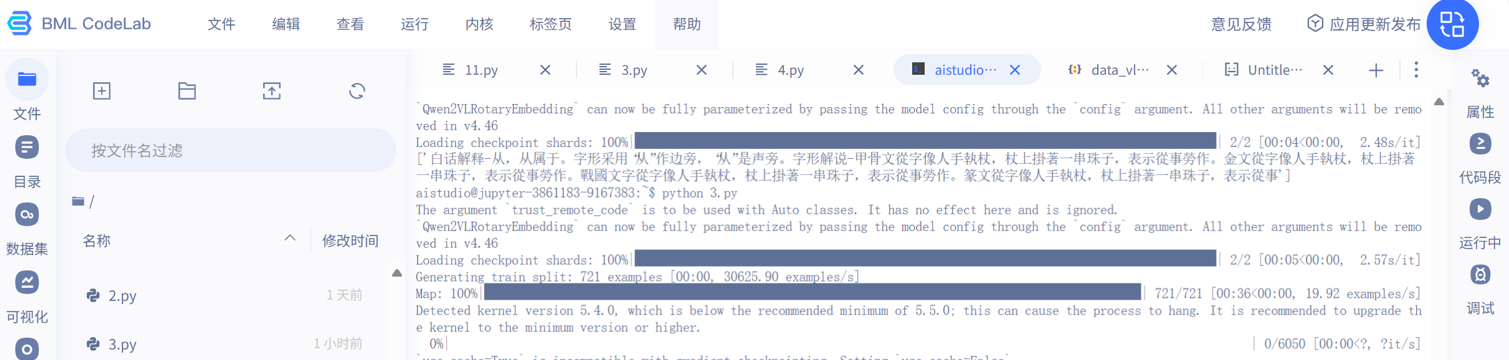

## 可以看到，经过LoRA微调后，模型在特定任务上的表现得到了提升，已经能判断甲骨文的释义了